# House Prices : Visualization & Prediction
### Predict sales prices and practice different machine learning regressors.

<img src="https://www.vancouverrealestatepodcast.com/wp-content/uploads/2018/10/Detached-home-prices.jpg" alt="Smiley face" height="50%" width="70%">




Getting started with competitive data science can be quite intimidating. So I build this notebook for quick overview on the Advanced Regression Techniques competition. If there is interest, I’m happy to do deep dives into the intuition behind the feature engineering and models used in this kernel.

I encourage you to fork this kernel, play with the code and enter the competition. Good luck!

If you like this kernel, please give it an upvote. Thank you!

**Competition Description**

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. Each row in the dataset describes the characteristics of a house. This competition challenges you to predict the final price of each home.

**Executive Summary**

I started this competition by just focusing on getting a good understanding of the dataset. The EDA & Visualizations are included to allow developers to dive into analysis of dataset. 


### Key features of the model training process in this kernel

- Cross Validation: Using 10-fold cross-validation
- Models: On each run of cross-validation tried fitting following models :-
    - Elastic model
    - Lasso regression model 
    - XGBoost model
    - LGBM model
    - SVR model
    - Ridge model
    - GBR model
- Stacking : Trained a meta StackingCVRegressor optimized using xgboost
- Blending: All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


# Data Cleaning and Pre-processing

In [3]:
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

### Basic Visualization

#### 1. Correlation among variables

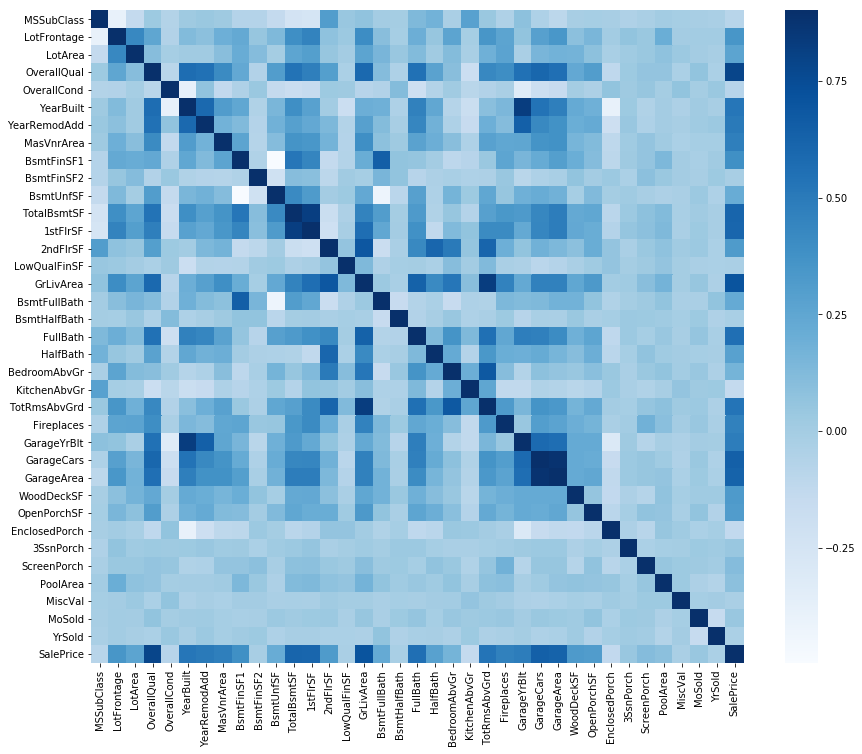

In [4]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

#### 2. Various datatypes columns

In [5]:
train.get_dtype_counts()

int64      34
object     43
float64     3
dtype: int64

#### 3. Heatmap

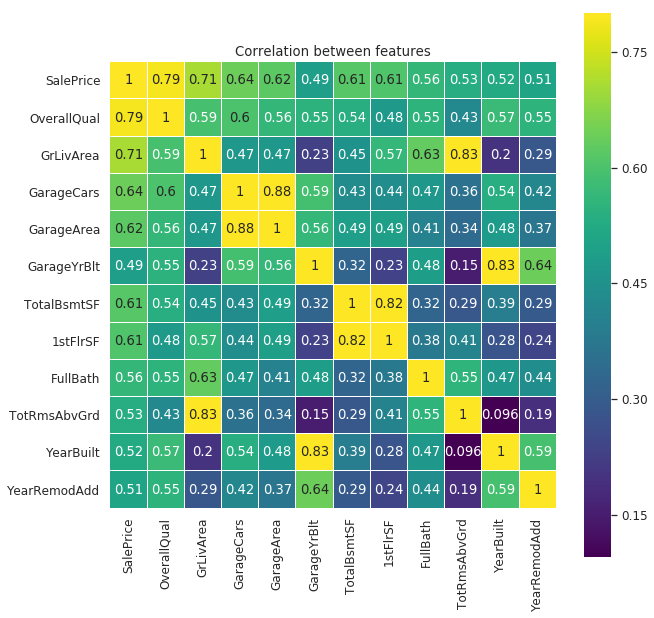

In [6]:
# Heatmap between top 10 correlated variables with SalePrice
corrMatrix=train[["SalePrice","OverallQual","GrLivArea","GarageCars",
                  "GarageArea","GarageYrBlt","TotalBsmtSF","1stFlrSF","FullBath",
                  "TotRmsAbvGrd","YearBuilt","YearRemodAdd"]].corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(10, 10))

sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between features');

#### 4. SalePrice: the variable we're trying to predict

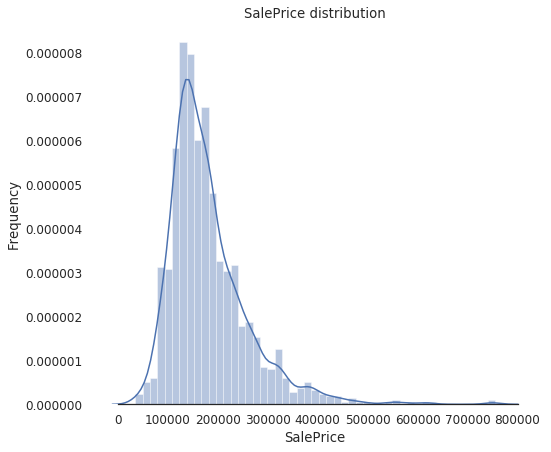

In [7]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [8]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


#### 5. Fireplaces Variable Factor

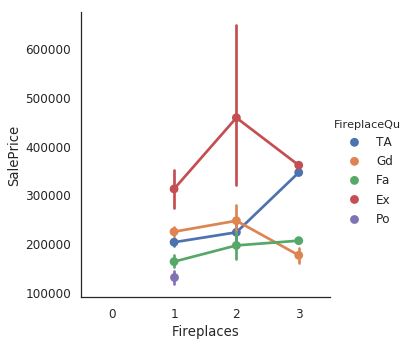

In [9]:
sns.factorplot("Fireplaces","SalePrice",data=train,hue="FireplaceQu");

Having 2 fireplaces increases house price and fireplace of Excellent quality is a big plus

#### 6. MSZoning

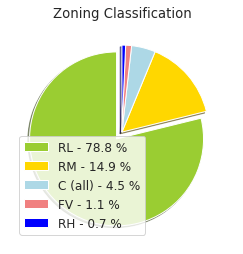

In [10]:
labels = train["MSZoning"].unique()
sizes = train["MSZoning"].value_counts().values
explode=[0.1,0,0,0,0]
parcent = 100.*sizes/sizes.sum()
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(labels, parcent)]

colors = ['yellowgreen', 'gold', 'lightblue', 'lightcoral','blue']
patches, texts= plt.pie(sizes, colors=colors,explode=explode,
                        shadow=True,startangle=90)
plt.legend(patches, labels, loc="best")

plt.title("Zoning Classification")
plt.show()

#### 7. SalePrice per square foot

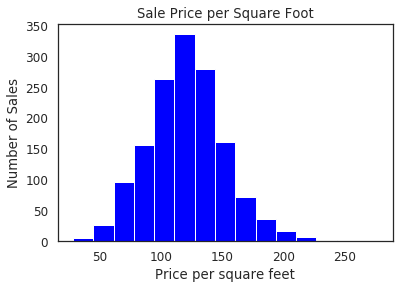

In [11]:
train1 = train
train1['SalePriceSF'] = train['SalePrice']/train['GrLivArea']
plt.hist(train['SalePriceSF'], bins=15,color="blue")
plt.title("Sale Price per Square Foot")
plt.ylabel('Number of Sales')
plt.xlabel('Price per square feet');

#### 8. Building , remodelling years and age of house

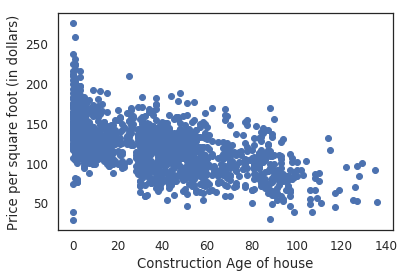

In [12]:
train1['ConstructionAge'] = train['YrSold'] - train['YearBuilt']
plt.scatter(train1['ConstructionAge'], train['SalePriceSF'])
plt.ylabel('Price per square foot (in dollars)')
plt.xlabel("Construction Age of house");

Price of house goes down with its age.

#### 9. Heating and AC arrangements

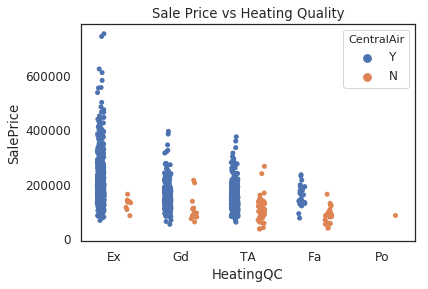

In [13]:
sns.stripplot(x="HeatingQC", y="SalePrice",data=train,hue='CentralAir',jitter=True,split=True)
plt.title("Sale Price vs Heating Quality");

Having Heating & AC arrangements definitely escalates price of house.

#### 10. Kitchen Quality

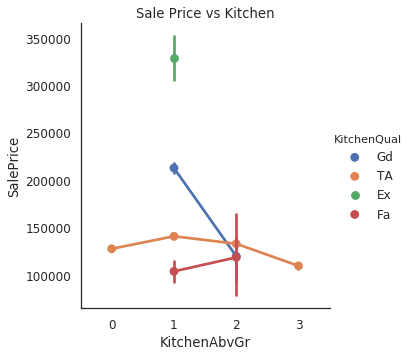

In [14]:
sns.factorplot("KitchenAbvGr","SalePrice",data=train,hue="KitchenQual")
plt.title("Sale Price vs Kitchen");

Having only one Kitchen of Ex (Excellent) quality hikes house price like anything.

### Outlier

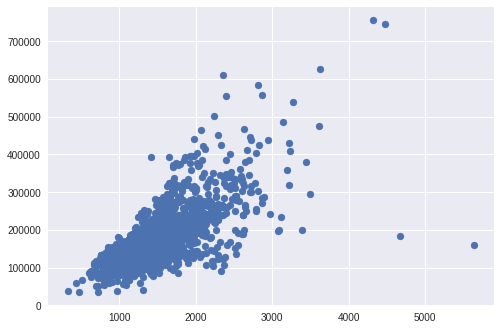

In [15]:
plt.style.use('seaborn')
plt.scatter(train.GrLivArea, train.SalePrice)

In [16]:
# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

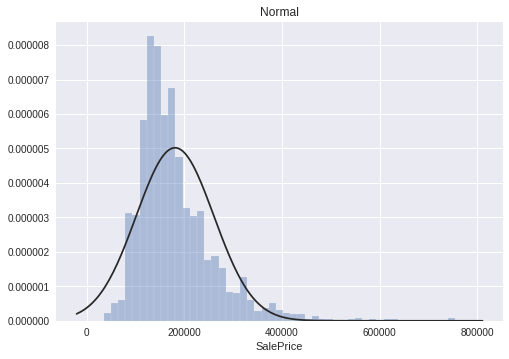

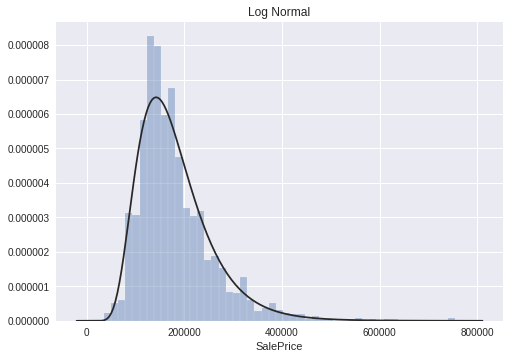

In [17]:
y = train['SalePrice']
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

There seems to be clear evidence of right-skewedness in the target variable. We can correct this with a simple log transformation.

In [18]:
train["SalePrice"] = np.log1p(train["SalePrice"])

# Feature Engineering

### Concatenation
To keep consistency between test and train features we concatenate the two sets while remembering the index so we can split it later again.

In [19]:
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [20]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(2917, 81)


### NA's
Let's figure out what NA's excist, sort them by categories and impute them in the best possible way.

In [21]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
features["PoolQC"] = features["PoolQC"].fillna("None")

Let's impute all incongruencies with the most likely value.

In [22]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')


Zoning is also interesting

In [23]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))


For the rest we will just use a loop to impute 'None' value

In [24]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

The lotfrontage averages differ a lot per neighborhood so let's impute with the median per neighborhood.

In [25]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

The rest can be safely imputed with 0 since this means that the property is not present in the house.

In [26]:
# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

### Features Simplication


In [27]:
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### Creating Dummies

Since sklearn lm.fit() does not accept strings we have to convert our objects to dummy variables.

In [28]:
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

(2917, 88)
(2917, 335)
X (1458, 335) y (1458,) X_sub (1459, 335)


### Overfitting prevention


In [29]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1453, 333) y (1453,) X_sub (1459, 333)


# Model

#### Setup cross validation method

In [30]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

#### Defining model scoring function 

In [31]:
# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)

#### Setting Up Models

In [32]:
# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# Ridge Regressor
ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

# Lasso Regressor
lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

# Elasticnet Regressor
elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))
                                        
# Support Vector Regressor
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

# Train models

#### Get cross validation scores for each model

In [33]:
print('TEST score on CV')

scores = {}

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),)
scores['ridge'] = (score.mean(), score.std())

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )
scores['lasso'] = (score.mean(), score.std())

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),)
scores['elasticnet'] = (score.mean(), score.std())

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),)
scores['svr'] = (score.mean(), score.std())

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )
scores['lgbm'] = (score.mean(), score.std())

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),)
scores['gbr'] = (score.mean(), score.std())

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )
scores['xgboost'] = (score.mean(), score.std())

TEST score on CV
Kernel Ridge score: 0.0485 (0.0082)

Lasso score: 0.0409 (0.0084)

ElasticNet score: 0.0409 (0.0084)

SVR score: 0.0420 (0.0102)

Lightgbm score: 0.0647 (0.0092)

GradientBoosting score: 0.0733 (0.0109)

[13:09:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:07] WARNIN

### Fit the models

In [34]:
print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
2019-12-15 13:12:05.280559 StackingCVRegressor
[13:13:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2019-12-15 13:16:01.390213 elasticnet
2019-12-15 13:16

# Blend models and get predictions

In [35]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))
            

# Get final precitions from the blended model
blended_score = rmsle(y, blend_models_predict(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.017094130084742677


### Blend with Top Kernals submissions

In [36]:
print('Predict submission', datetime.now(),)
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

# this kernel gives lower score
# let's up it by mixing with the top kernels

print('Blend with Top Kernals submissions', datetime.now(),)
sub_1 = pd.read_csv('../input/top-10-0-10943-stacking-mice-and-brutal-force/House_Prices_submit.csv')
sub_2 = pd.read_csv('../input/hybrid-svm-benchmark-approach-0-11180-lb-top-2/hybrid_solution.csv')
sub_3 = pd.read_csv('../input/lasso-model-for-regression-problem/lasso_sol22_Median.csv')

submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) + 
                                (0.25 * sub_1.iloc[:,1]) + 
                                (0.25 * sub_2.iloc[:,1]) + 
                                (0.25 * sub_3.iloc[:,1]))

Predict submission 2019-12-15 13:16:45.810995
Blend with Top Kernals submissions 2019-12-15 13:16:47.504069


### Deal with predictions close to outer range 

In [37]:
# Brutal approach to deal with predictions close to outer range 
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

submission.to_csv("submission.csv", index=False)
print('Save submission', datetime.now(),)

Save submission 2019-12-15 13:16:50.091264


### Identify the best performing model

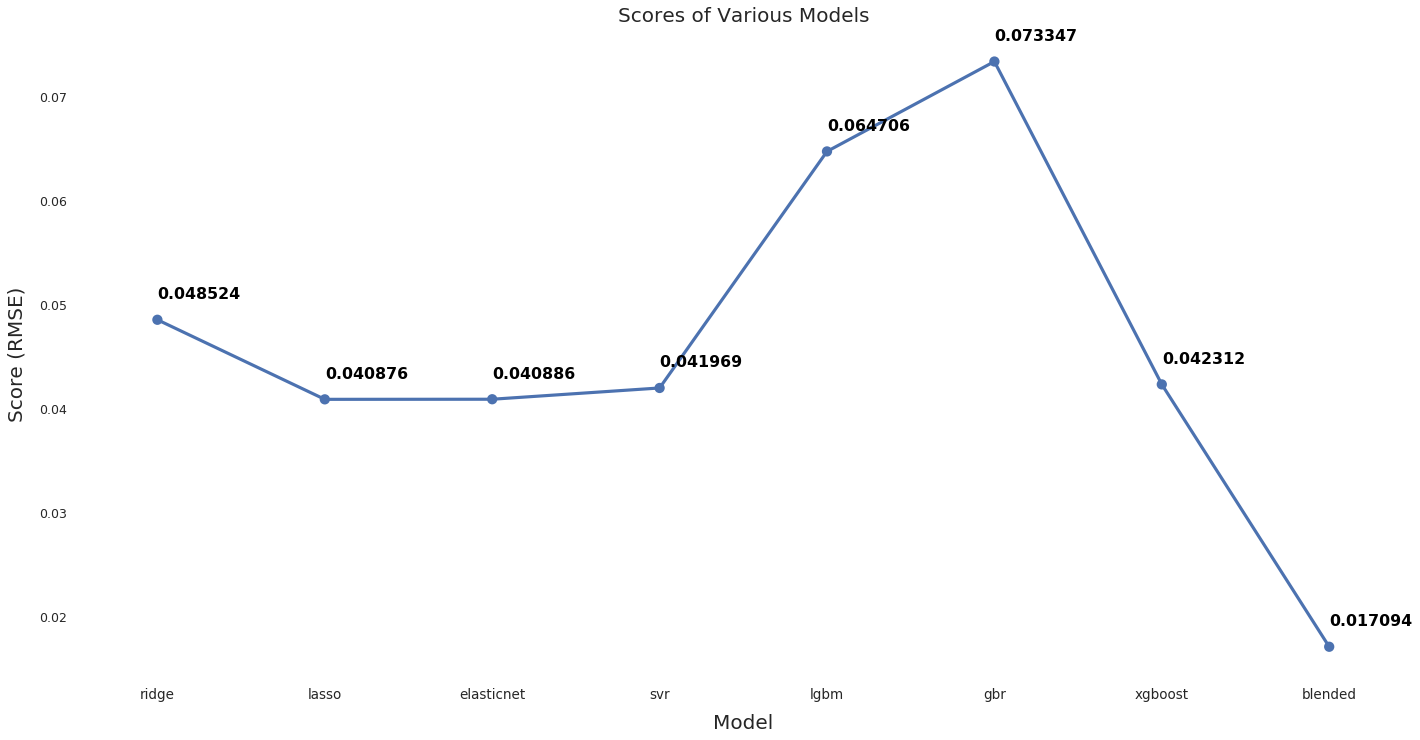

In [38]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Various Models', size=20)

plt.show()

We can observe from the graph above that the blended model far outperforms the other models, with an RMSLE of 0.0170 .  This is the model which will be used for making the final predictions.

# Acknowledgments

Inspirations are drawn from various Kaggle notebooks but majorly motivation is from the following :

1. https://www.kaggle.com/poonaml/house-prices-data-exploration-and-visualisation

2. https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition
 
3. https://www.kaggle.com/itslek/blend-stack-lr-gb-0-10649-house-prices-v57/data?scriptVersionId=11189608
 
4. https://www.kaggle.com/hemingwei/top-2-from-laurenstc-on-house-price-prediction/notebook

5. https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1

##### Credit for image to https://www.vancouverrealestatepodcast.com/tag/housing-price-prediction-2019/